## Overview
Spotify's Web API provides access to the song details. The data for this project has been taken from here: https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-01-21/readme.md <br>
The dataset contains track, playlist, artist details and popularity along with 12 audio features.
Each track has 12 audio features: confidence measure like acousticness, liveness, speechiness, and instrumentalness, as well as perceptual measurements like energy, loudness, danceability, and valence (positiveness) and descriptors like duration, tempo, key, and mode. <br>
With this data we want to analyze the following: <br>

###### Understand and explore the dataset to report interesting facts. <br> Is it possible to classify songs into genres with just audio features? Also what are the most important feature to classify songs into different genres? Based on auditory features, what are the similar playlists?

In [0]:
# File location and type
file_location = "/FileStore/tables/spotify_songs.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

#display(df)

In [0]:
df.dtypes

Out[2]: [('track_id', 'string'),
 ('track_name', 'string'),
 ('track_artist', 'string'),
 ('track_popularity', 'int'),
 ('track_album_id', 'string'),
 ('track_album_name', 'string'),
 ('track_album_release_date', 'string'),
 ('playlist_name', 'string'),
 ('playlist_id', 'string'),
 ('playlist_genre', 'string'),
 ('playlist_subgenre', 'string'),
 ('danceability', 'string'),
 ('energy', 'string'),
 ('key', 'string'),
 ('loudness', 'string'),
 ('mode', 'string'),
 ('speechiness', 'double'),
 ('acousticness', 'double'),
 ('instrumentalness', 'double'),
 ('liveness', 'double'),
 ('valence', 'double'),
 ('tempo', 'double'),
 ('duration_ms', 'double')]

In [0]:
df=df.withColumn("track_album_release_date",df.track_album_release_date.cast('date')) 

In [0]:
df=df.withColumn("danceability",df.danceability.cast('float')). \
    withColumn("energy",df.energy.cast('float')). \
    withColumn("key",df.key.cast('float')). \
    withColumn("loudness",df.loudness.cast('float')). \
    withColumn("mode",df.mode.cast('float')). \
    withColumn("speechiness",df.speechiness.cast('float')). \
    withColumn("acousticness",df.acousticness.cast('float')). \
    withColumn("instrumentalness",df.instrumentalness.cast('float')). \
    withColumn("liveness",df.liveness.cast('float')). \
    withColumn("valence",df.valence.cast('float')). \
    withColumn("tempo",df.tempo.cast('float'))
    

In [0]:
from pyspark.sql.functions import col

df = df.withColumn('Duration_minutes', (col('duration_ms')/60000))


In [0]:
from pyspark.sql.functions import col
from pyspark.sql import functions as F
df = df.withColumn(('Duration_minutes'), F.round(col("Duration_minutes"), 2))

In [0]:
# Create a view or table

temp_table_name = "spotify_songs_csv"

df.createOrReplaceTempView(temp_table_name)

In [0]:
# With this registered as a temp view, it will only be available to this particular notebook. If you'd like other users to be able to query this table, you can also create a table from the DataFrame.
# Once saved, this table will persist across cluster restarts as well as allow various users across different notebooks to query this data.
# To do so, choose your table name and uncomment the bottom line.
spark.conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true")
permanent_table_name = "spotifysongs"

df.write.format("parquet").saveAsTable(permanent_table_name)

In [0]:
print((df.count(), len(df.columns)))

(32833, 24)


### Exploratory Data Analysis

##### Top 50 songs with popularity_score > 90

In [0]:
from pyspark.sql.functions import col
df.filter("track_popularity > 90").select('track_name','track_artist','track_popularity').dropDuplicates(['track_name']).orderBy(col("track_popularity").desc()).show(50)

+--------------------+-------------------+----------------+
|          track_name|       track_artist|track_popularity|
+--------------------+-------------------+----------------+
|             ROXANNE|     Arizona Zervas|              99|
|             The Box|        Roddy Ricch|              98|
|                Tusa|            KAROL G|              98|
|     Blinding Lights|         The Weeknd|              98|
|             Circles|        Post Malone|              98|
|            Memories|           Maroon 5|              98|
|     Don't Start Now|           Dua Lipa|              97|
|             Falling|      Trevor Daniel|              97|
| everything i wanted|      Billie Eilish|              97|
|RITMO (Bad Boys F...|The Black Eyed Peas|              96|
|             bad guy|      Billie Eilish|              95|
|               Yummy|      Justin Bieber|              95|
|My Oh My (feat. D...|     Camila Cabello|              94|
| HIGHEST IN THE ROOM|       Travis Scot

##### Which song genre has the highest number of popular songs?

In [0]:
df.filter("track_popularity > 81").groupby('playlist_genre').agg({'track_popularity':'count'}).withColumnRenamed("count(track_popularity)", "No. of songs").orderBy(col('count(track_popularity)').desc()).show()

+--------------+------------+
|playlist_genre|No. of songs|
+--------------+------------+
|         latin|         331|
|           pop|         293|
|           r&b|         261|
|           rap|         133|
|           edm|         120|
|          rock|          35|
+--------------+------------+



In [0]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.offline as pyo

##### Who are the top Artists by number of popular songs? (popularity > 81)

In [0]:
df.filter("track_popularity > 81").groupby('track_artist').agg({'track_popularity':'count'}).withColumnRenamed("count(track_popularity)", "No. of songs").orderBy(col('count(track_popularity)').desc()).show(50)

+----------------+------------+
|    track_artist|No. of songs|
+----------------+------------+
|      Ed Sheeran|          37|
|   Billie Eilish|          29|
|     Post Malone|          28|
|    Travis Scott|          26|
|    Selena Gomez|          26|
|    Shawn Mendes|          24|
|      The Weeknd|          19|
|  Camila Cabello|          19|
|      Young Thug|          19|
|          Khalid|          18|
|The Chainsmokers|          18|
|    Harry Styles|          17|
|        J Balvin|          17|
|          Halsey|          17|
|           Drake|          17|
|           Dalex|          16|
|   Lewis Capaldi|          15|
|        Dua Lipa|          15|
|      Juice WRLD|          15|
|      Marshmello|          14|
|       Bad Bunny|          14|
|          MEDUZA|          12|
|          DaBaby|          12|
|   Calvin Harris|          12|
|     Roddy Ricch|          11|
|       Sam Smith|          11|
|        Anuel AA|          11|
|   Ariana Grande|          11|
|       

/databricks/python/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

Out[14]: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Ed Sheeran'),
  Text(1, 0, 'Billie Eilish'),
  Text(2, 0, 'Post Malone'),
  Text(3, 0, 'Selena Gomez'),
  Text(4, 0, 'Travis Scott'),
  Text(5, 0, 'Shawn Mendes'),
  Text(6, 0, 'The Chainsmokers'),
  Text(7, 0, 'Khalid'),
  Text(8, 0, 'Young Thug'),
  Text(9, 0, 'Camila Cabello')])

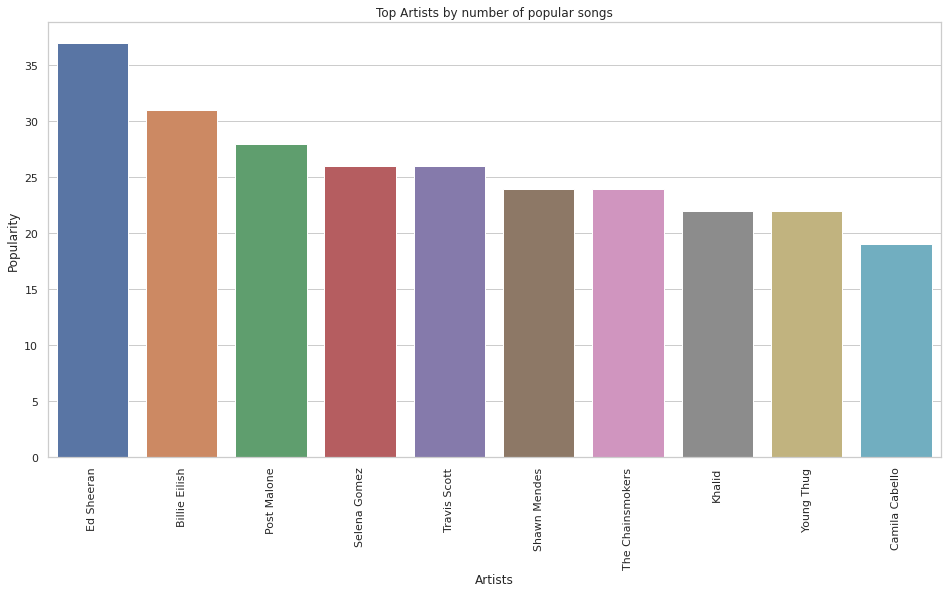

In [0]:
import numpy as np
dfnew = df.toPandas()
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
idx = np.where((dfnew['track_popularity']>=81))
df1 = dfnew.loc[idx]
x = df1.groupby("track_artist")["track_popularity"].count().sort_values(ascending=False).head(10)
ax = sns.barplot(x.index, x)
ax.set_title('Top Artists by number of popular songs')
ax.set_ylabel('Popularity')
ax.set_xlabel('Artists')
plt.xticks(rotation = 90)

##### Which genre of songs are more in the Spotify playlists?

Out[15]: Text(0.5, 1.0, 'Distribution of Genres in Spotify playlist')

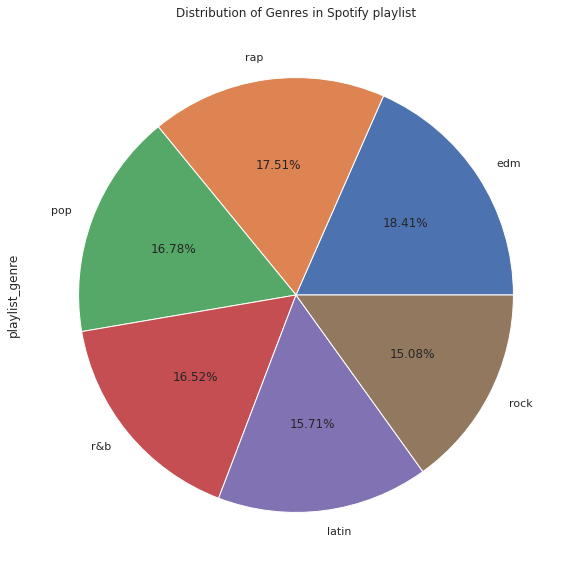

In [0]:
dfnew['playlist_genre'].value_counts().head(6).plot.pie(figsize=(10,10),autopct='%2.2f%%')
plt.title('Distribution of Genres in Spotify playlist')


##### Histogram plot for various audio features to understand outliers if any

Out[16]: Text(0.5, 1.0, 'Histogram plot of various song attributes')

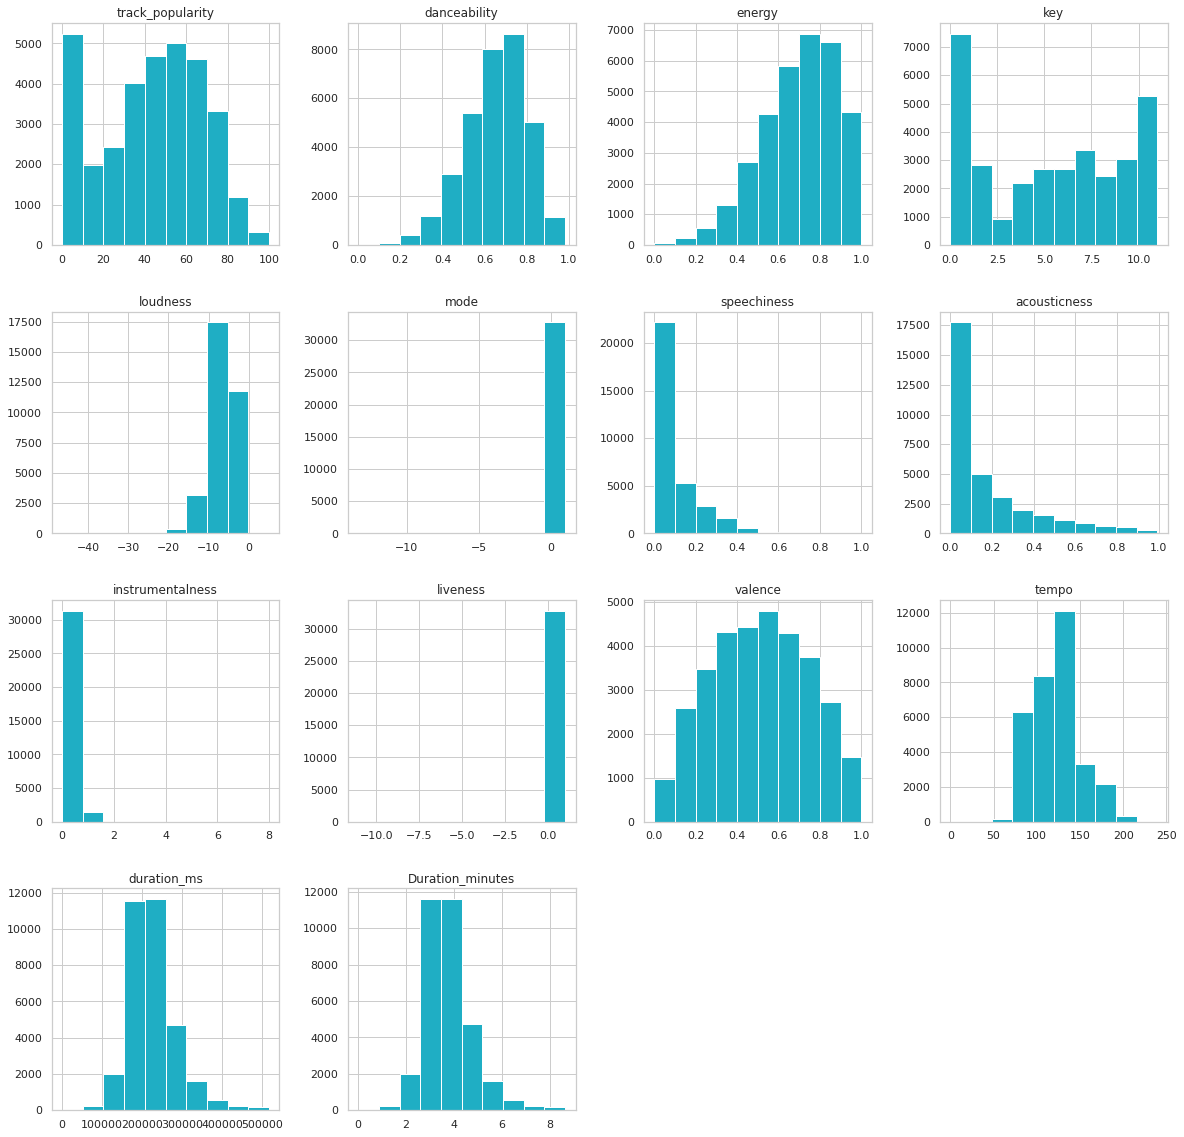

In [0]:
dfnew.hist(figsize=(20,20), color = "#1faec4")
plt.title("Histogram plot of various song attributes", size=20, weight='bold')

##### What is the Correlation between the audio features and track popularity?

In [0]:
df_heatmap=df.select('danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness',
                                 'valence','tempo','track_popularity')

In [0]:
df_heatmap=df_heatmap.toPandas()

Out[19]: <AxesSubplot:>

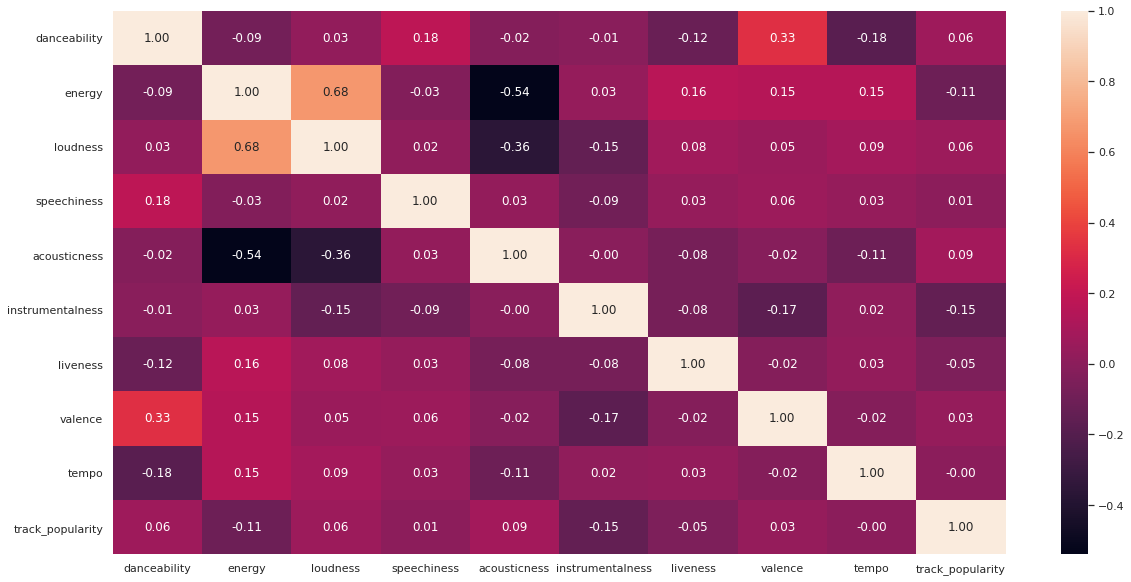

In [0]:
plt.figure(figsize=(20,10))
sns.heatmap(df_heatmap.corr(), annot=True, fmt='.2f')

Across all songs and genres in the dataset, energy and loudness are fairly highly correlated (0.68). <br>
Energy and acousticness are negatively correlated. Acoustic music, as we all know, is frequently quiet and takes attentive listening. . That’s why it makes a negative correlation with energy and loudness, which makes sense. <br>
There is positive correlation between danceability and valence (happier songs lead to more dancing).<br>
Interestingly, danceability is negatively correlated with tempo, liveness and energy.
We can observe that there is no significant positive correlation between a single song feature and its popularity.

#### What are the top 5 popular albums? (Albums with at least 10 tracks)

In [0]:
%sql
with data1 as (
select 
 distinct track_id
,track_artist
,track_album_id
,track_album_name
,track_popularity
from spotifysongs
)
select 
 track_album_id
,track_artist
,track_album_name
,avg(track_popularity) as album_popularity
from data1
group by track_artist, track_album_name, track_album_id
having count(track_id) > 10
order by album_popularity desc limit 5

track_album_id,track_artist,track_album_name,album_popularity
0S0KGZnfBGSIssfF54WSJh,Billie Eilish,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",83.72727272727273
7CjJb2mikwAWA1V6kewFBF,Bad Bunny,X 100PRE,73.26666666666667
4CzT5ueFBRpbILw34HQYxi,2Pac,All Eyez On Me,63.07692307692308
2HTbQ0RHwukKVXAlTmCZP2,The Notorious B.I.G.,Ready to Die (The Remaster),60.833333333333336
3tQd5mwBtVyxCoEo4htGAV,Wu-Tang Clan,Enter The Wu-Tang (36 Chambers) [Expanded Edition],60.63636363636363


#### What are the top 5 popular tracks in each playlist?

In [0]:
%sql
with data1 as (
select 
 playlist_id
,track_popularity
,dense_rank() over(partition by playlist_id order by track_popularity desc) as Rank
,track_artist
,track_name
,track_album_name
,playlist_name 
from spotifysongs
) 
select * 
from data1 
where Rank <= 5 
order by playlist_id, Rank

playlist_id,track_popularity,Rank,track_artist,track_name,track_album_name,playlist_name
Si-Tew,30,1,Robert Owens,Be Your Own Hero - John Gazoo White Shoe Remix,"""Black Label #78 """" Art """" Remix EP 2 - Remixes by Christo",Niedermeier & Whitehead
0275i1VNfBnsNbPl0QIBpG,77,1,Playboi Carti,Shoota (feat. Lil Uzi Vert),Die Lit,Hip-Hop 'n RnB
0275i1VNfBnsNbPl0QIBpG,74,2,The Notorious B.I.G.,Big Poppa - 2005 Remaster,Ready to Die (The Remaster),Hip-Hop 'n RnB
0275i1VNfBnsNbPl0QIBpG,71,3,50 Cent,In Da Club,Get Rich Or Die Tryin',Hip-Hop 'n RnB
0275i1VNfBnsNbPl0QIBpG,70,4,JAY-Z,No Church In The Wild,Watch The Throne (Deluxe),Hip-Hop 'n RnB
0275i1VNfBnsNbPl0QIBpG,69,5,Ice Cube,Check Yo Self - Remix,Bootlegs And B-Sides,Hip-Hop 'n RnB
0275i1VNfBnsNbPl0QIBpG,69,5,50 Cent,21 Questions,Get Rich Or Die Tryin',Hip-Hop 'n RnB
03qQtbNHoJuFezRu2CnLuF,78,1,Aerosmith,Dream On,Aerosmith,Permanent Wave
03qQtbNHoJuFezRu2CnLuF,77,2,Gotye,Somebody That I Used To Know,Making Mirrors,Permanent Wave
03qQtbNHoJuFezRu2CnLuF,75,3,George Michael,Careless Whisper,Ladies And Gentlemen... The Best Of George Michael,Permanent Wave


#### Which artist has the highest number of songs in the most popular playlist?

In [0]:
%sql
with data1 as (
select 
 playlist_id
,avg(track_popularity) as playlist_popularity 
from spotifysongs 
group by playlist_id
),
data2 as (
select *
,row_number() over (order by playlist_popularity desc) as Rank 
from data1
)
select 
 s.playlist_name
,s.track_artist
,count(s.track_id) as num_track
from data2 d
join spotifysongs s on d.playlist_id = s.playlist_id and d.Rank = 1 
group by s.track_artist, s.playlist_name
order by num_track desc

playlist_name,track_artist,num_track
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,Khalid,16
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,Harry Styles,8
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,The Chainsmokers,7
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,Ed Sheeran,7
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,Selena Gomez,7
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,Post Malone,7
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,Travis Scott,6
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,Lil Nas X,6
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,Chris Brown,6
2020 Hits & 2019 Hits – Top Global Tracks 🔥🔥🔥,Kygo,6


In [0]:
# Selecting the dependent and the independent variables that are identified as most useful attributes to estimate duration

data=df.select(['danceability','energy','key','loudness',
                                 'mode','speechiness','acousticness','instrumentalness','liveness',
                                 'valence','tempo','Duration_minutes','track_popularity','playlist_genre'])

In [0]:
#df.na.fill(value=0).show()

In [0]:
data=data.dropna()

In [0]:
data.count()

Out[23]: 32821

In [0]:
# Create a 70-30 train test split

 

train_data,test_data=data.randomSplit([0.7,0.3])

### Implementing Decision Tree Classifier to classify songs genres

###### Our aim is to find out if is it possible to classify songs into genres with just audio features; Also our aim is to find the most important features used by the decision tree.

In [0]:
# Import the required libraries

from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.feature import VectorAssembler,StringIndexer
from pyspark.ml import Pipeline

In [0]:
genre_indexer = StringIndexer(inputCol='playlist_genre',outputCol='genre_index',handleInvalid='keep')

In [0]:
# Vector assembler is used to create a vector of input features

assembler = VectorAssembler(inputCols=['danceability','energy','loudness','mode','key',
                                 'speechiness','acousticness','instrumentalness','liveness',
                                 'valence','tempo'],
                            outputCol="features")

In [0]:
# Create an object for the Logistic Regression model
# Use the parameter maxBins and assign a value that is equal to or more than the number of categories in any sigle feature

dt_model = DecisionTreeClassifier(labelCol='genre_index',maxDepth=4)

In [0]:
# Pipeline is used to pass the data through indexer and assembler simultaneously. Also, it helps to pre-rocess the test data
# in the same way as that of the train data

pipe = Pipeline(stages=[genre_indexer,assembler,dt_model])


In [0]:
# It took 8 minutes for this step to execute

fit_model=pipe.fit(train_data)

In [0]:
va = fit_model.stages[-2]
tree = fit_model.stages[-1]

In [0]:
display(tree) #visualize the decision tree model


treeNode
"{""index"":15,""featureType"":""continuous"",""prediction"":null,""threshold"":0.15450000017881393,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":7,""featureType"":""continuous"",""prediction"":null,""threshold"":0.5614999830722809,""categories"":null,""feature"":0,""overflow"":false}"
"{""index"":3,""featureType"":""continuous"",""prediction"":null,""threshold"":0.6414999961853027,""categories"":null,""feature"":1,""overflow"":false}"
"{""index"":1,""featureType"":""continuous"",""prediction"":null,""threshold"":0.0393499992787838,""categories"":null,""feature"":5,""overflow"":false}"
"{""index"":0,""featureType"":null,""prediction"":5.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":2,""featureType"":null,""prediction"":3.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":5,""featureType"":""continuous"",""prediction"":null,""threshold"":0.35249999165534973,""categories"":null,""feature"":9,""overflow"":false}"
"{""index"":4,""featureType"":null,""prediction"":0.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":6,""featureType"":null,""prediction"":5.0,""threshold"":null,""categories"":null,""feature"":null,""overflow"":false}"
"{""index"":11,""featureType"":""continuous"",""prediction"":null,""threshold"":120.00650024414062,""categories"":null,""feature"":10,""overflow"":false}"


In [0]:
print(tree.toDebugString)
list(zip(va.getInputCols(), tree.featureImportances))

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_3c7cd4e44ba8, depth=4, numNodes=23, numClasses=7, numFeatures=11
  If (feature 5 <= 0.15450000017881393)
   If (feature 0 <= 0.5614999830722809)
    If (feature 1 <= 0.6414999961853027)
     If (feature 5 <= 0.0393499992787838)
      Predict: 5.0
     Else (feature 5 > 0.0393499992787838)
      Predict: 3.0
    Else (feature 1 > 0.6414999961853027)
     If (feature 9 <= 0.35249999165534973)
      Predict: 0.0
     Else (feature 9 > 0.35249999165534973)
      Predict: 5.0
   Else (feature 0 > 0.5614999830722809)
    If (feature 10 <= 120.00650024414062)
     If (feature 2 <= -7.286499977111816)
      Predict: 3.0
     Else (feature 2 > -7.286499977111816)
      Predict: 4.0
    Else (feature 10 > 120.00650024414062)
     If (feature 10 <= 130.04149627685547)
      Predict: 0.0
     Else (feature 10 > 130.04149627685547)
      Predict: 1.0
  Else (feature 5 > 0.15450000017881393)
   If (feature 1 <= 0.9034999907016754)
    Predi

Most important features in decision tree to classify songs: speechiness, tempo, danceability and energy

In [0]:
# Store the results in a dataframe

results = fit_model.transform(test_data)

In [0]:
results.select(['genre_index','prediction']).show()

+-----------+----------+
|genre_index|prediction|
+-----------+----------+
|        4.0|       0.0|
|        2.0|       5.0|
|        5.0|       5.0|
|        4.0|       0.0|
|        4.0|       0.0|
|        5.0|       5.0|
|        1.0|       5.0|
|        5.0|       5.0|
|        4.0|       0.0|
|        5.0|       0.0|
|        5.0|       0.0|
|        5.0|       5.0|
|        5.0|       5.0|
|        2.0|       3.0|
|        5.0|       5.0|
|        5.0|       3.0|
|        5.0|       5.0|
|        5.0|       5.0|
|        5.0|       5.0|
|        2.0|       0.0|
+-----------+----------+
only showing top 20 rows



Evaluating Decision Tree

In [0]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [0]:
ACC_evaluator = MulticlassClassificationEvaluator(
    labelCol="genre_index", predictionCol="prediction", metricName="accuracy")

In [0]:
accuracy = ACC_evaluator.evaluate(results)

In [0]:
print("The accuracy of the decision tree classifier is {}".format(accuracy))

The accuracy of the decision tree classifier is 0.41175875328880795


#### Based on auditory features, what are the similar playlists? (K-Means with Elbow method)

In [0]:
%sql
select playlist_id, avg(danceability) as danceability,
 avg(energy) as energy,
 avg(loudness) as loudness,
 avg(speechiness) as speechiness,
 avg(acousticness) as acousticness,
 avg(instrumentalness) as instrumentalness,
 avg(liveness) as liveness,
 avg(valence) as valence,
 avg(tempo) as tempo,
 avg(Duration_minutes) as time 
 from spotifysongs group by playlist_id

playlist_id,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time
4lIywN6kXl9KPm3OQ8u8G7,0.6110222230354945,0.7414000007841323,-8.156977791256375,0.04636666646434201,0.11666693429967077,0.051072843648229435,0.1736599996685982,0.6995333343744278,123.9363771226671,4.148444444444444
3HjTMn6O6adW8vcSMnqmhw,0.661739126495693,0.7176521718502045,-10.11299997827281,0.04175217409172784,0.08321886933845235,0.11128898031830906,0.15347391366958618,0.75695652158364,116.94173829451852,4.412608695652175
0NCspsyf0OS4BsPgGhkQXM,0.5246800020337105,0.7320000016689301,-5.915810010433197,0.10123800000175834,0.14060286798270683,0.11822751383621494,0.17938800096511842,0.27887599878013136,131.07390022277832,3.3764999999999996
37i9dQZF1DWY6tYEFs22tT,0.7976136336272414,0.5773636407472871,-7.262909065593373,0.23545454518700187,0.15498704500813884,0.00393946394175838,0.1444454545324499,0.5363181810826063,123.07513687827371,3.0318181818181826
1bMYfBHYBCRHY5LGkjlpSy,0.5358877560617973,0.7224897946021995,-8.299438778234988,0.060331632554226994,0.16594433605348746,0.04156556815906019,0.17707244800973912,0.6067346948750165,125.35485715282206,4.295306122448978
37i9dQZF1DX0ES2mnOVvai,0.21610588185927448,0.6483044125146561,-24.868588110979864,0.12694705956998995,0.37861719061637655,0.6097292448714998,0.45141176660271254,0.04456176417550202,118.41793980317958,3.3135294117647054
37i9dQZF1DXc8kgYqQLMfH,0.6335099983215332,0.24322499983012677,-13.890649967193603,0.1544630005955696,0.7385120004788042,0.8113280950579792,0.12011800058186055,0.4416340010613203,103.92849002838135,1.9438000000000002
0TT57Pe3RZNGCy98G1UQpM,0.6808999940752983,0.8183500021696091,-6.115349996089935,0.06210000040009618,0.33207000195980074,0.00306286606547701,0.2490200012922287,0.8021500051021576,122.97065010070801,4.144
4E3K9oQgvLcKEz0wgBBXxD,0.4516190489133199,0.6230404804505053,-8.74109523069291,0.03504047609333481,0.09657733334391932,0.022453590456128342,0.1660785714962653,0.3619119044215906,122.59940483456566,3.8900000000000006
6kXNv8J3HCYztxjOIUzApv,0.45909589018723734,0.9080547943507156,-4.641986278638448,0.09847260271645572,0.004603727233008039,0.03333998584980068,0.24121780928275358,0.443493150072555,134.06367126882893,3.9682191780821925


#### Building the K Means model

In [0]:
# Import the required libraries
 
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [0]:
# Vector assembler is used to create a vector of input features
assembler = VectorAssembler(inputCols=['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'Duration_minutes'],
                            outputCol="unscaled_features")

In [0]:
# Standard scaler is used to scale the data for the linear SVC to perform well on the training data
scaler = StandardScaler(inputCol="unscaled_features",outputCol="features")

In [0]:
# Pipeline is used to pass the data through assembler. Also, it helps to pre-rocess the test data in the same way as that of the train data.
pipe = Pipeline(stages=[assembler, scaler])

In [0]:
# It took 1 minute for this step to complete execution
final_data=pipe.fit(data).transform(data)

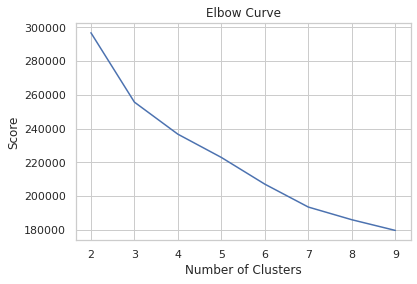

In [0]:
import numpy as np
import pandas as pd 
from pyspark import SparkContext
from pyspark import SparkConf
# Calculate cost and plot
cost = np.zeros(10)
 
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(final_data)
    cost[k] = model.summary.trainingCost
 
# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2, 3, 4, 5, 6, 7, 8, 9]
df_cost.insert(0, 'cluster', new_col)
 
import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [0]:
# Create an object for the model
kmeans_model = KMeans(k=7)

In [0]:
fit_model = kmeans_model.fit(final_data)

In [0]:
wssse = fit_model.summary.trainingCost # for spark 3.0
print("The within set sum of squared error of the mode is {}".format(wssse))


The within set sum of squared error of the mode is 199061.45807294387


In [0]:
centers = fit_model.clusterCenters()


In [0]:
print("Cluster Centers")
index=1
for cluster in centers:
    print("Centroid {}: {}".format(index,cluster))
    index+=1

Cluster Centers
Centroid 1: [ 5.01500147  4.38603687 -1.7204848   0.76764837  0.62707224  0.0624246
  1.06169721  3.10131817  4.35398809  3.55424841]
Centroid 2: [ 4.54512314  4.37636995 -2.28969699  0.70357665  0.31161185  3.36706739
  1.23290639  1.62761275  4.66321026  4.14177354]
Centroid 3: [ 3.67236965  4.49431652 -1.68948295  0.72376328  0.28706889  0.11503772
  1.66351391  1.59560802  4.89396444  3.67473156]
Centroid 4: [ 4.32913326  3.44609336 -3.16815827  0.60570319  0.64135123  0.18208989
  1.06151113  2.41927054  4.43169281  5.14093944]
Centroid 5: [ 5.23632255  3.21644172 -2.4696986   1.27905096  0.83994586  0.04872333
  0.99850383  1.96110331  3.9099246   3.42442344]
Centroid 6: [ 4.70048005  3.85617754 -2.15631348  3.32820196  0.83014398  0.05457015
  1.44134568  2.42538123  5.10639253  3.60461716]
Centroid 7: [ 3.99288849  2.15818971 -3.62636657  0.7414902   2.99473166  0.60582156
  1.01098478  1.63363303  4.21864074  3.53304294]


In [0]:
# Store the results in a dataframe
results = fit_model.transform(final_data)

In [0]:
df_cluster = results.select(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 
                'tempo', 'Duration_minutes','prediction'])

In [0]:
results.groupby('prediction').count().sort('prediction').show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 7853|
|         1| 2421|
|         2| 7470|
|         3| 3427|
|         4| 5459|
|         5| 3221|
|         6| 2970|
+----------+-----+



In [0]:
display(df_cluster)

danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,Duration_minutes,prediction
0.748,0.916,-2.634,0.0583,0.102,0.0,0.0653,0.518,122.036,3.25,0
0.726,0.815,-4.969,0.0373,0.0724,0.00421,0.357,0.693,99.972,2.71,0
0.675,0.931,-3.432,0.0742,0.0794,2.33E-5,0.11,0.613,124.008,2.94,0
0.718,0.93,-3.778,0.102,0.0287,9.43E-6,0.204,0.277,121.956,2.82,2
0.65,0.833,-4.672,0.0359,0.0803,0.0,0.0833,0.725,123.976,3.15,0
0.675,0.919,-5.385,0.127,0.0799,0.0,0.143,0.585,124.982,2.72,0
0.449,0.856,-4.788,0.0623,0.187,0.0,0.176,0.152,112.648,3.13,2
0.542,0.903,-2.419,0.0434,0.0335,4.83E-6,0.111,0.367,127.936,3.46,2
0.594,0.935,-3.562,0.0565,0.0249,3.97E-6,0.637,0.366,127.015,3.22,2
0.642,0.818,-4.552,0.032,0.0567,0.0,0.0919,0.59,124.957,4.22,0


#### Visualize Clustering using the PCA
We'll use a dimensionality reduction technique called PCA to display the 4-dimensional data into two dimensions. Spark has its own PCA flavor.
k=2 indicates the number of primary components in the PCA.

In [0]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(final_data)
pca_transformed = pca_model.transform(final_data)

In [0]:
#Next, extract the principal components
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [0]:
#Next, retrieve the cluster assignments from k-means assignments.
cluster_assignment = np.array(results.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

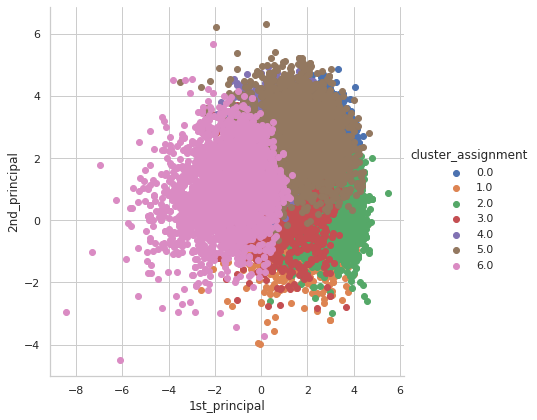

In [0]:
#Finally, plot the principal components.
import seaborn as sns
import matplotlib.pyplot as plt

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()